In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, cluster
import scipy as sp

In [25]:
dtf = pd.read_csv('Clean_Boston_Crime_Data.csv')
dtf['Date'] = pd.to_datetime(dtf['Date'])
dtf = dtf.set_index(['Date'])
dtf = dtf.loc['2022-4-1':'2022-4-20']
X = dtf[['Lat', 'Long']]
max_k = 10
X

,Lat,Long
Date,,
2022-04-09,42.297555,-71.059709
2022-04-13,42.310820,-71.112080
2022-04-15,42.355807,-71.149322
2022-04-15,42.349322,-71.072102
2022-04-15,42.312158,-71.070568
...,...,...
2022-04-10,42.339542,-71.069409
2022-04-11,42.349056,-71.150498
2022-04-11,42.329500,-71.077414


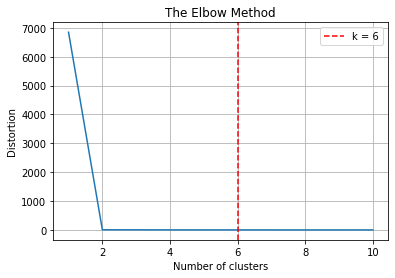

In [26]:
# iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_)

# best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))

# plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

In [30]:
k = 6
model = cluster.KMeans(n_clusters=k, init='k-means++')

# Clustering
dtf_X = X.copy()
dtf_X["cluster"] = model.fit_predict(X)

# Find real centroids
closest, distances = sp.cluster.vq.vq(model.cluster_centers_, dtf_X.drop("cluster", axis=1).values)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1

# Add clustering info to the original dataset
dtf[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]

C:\Users\Santhanagopalan\AppData\Local\Temp\ipykernel_4676\4179147005.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_X["centroids"].iloc[i] = 1


In [36]:
# Crime Hotspots
Centroids = dtf.copy()
Centroids.query('centroids == 1', inplace = True)
Centroids = Centroids[['Street', 'Lat', 'Long']]
Centroids = Centroids.reset_index(drop=True)
Centroids

,Street,Lat,Long
0,POPLAR ST,4.227405e+01,-7.112847e+01
1,STATE ST,4.235943e+01,-7.105289e+01
2,CHELSEA ST & SHELBY ST,1.327276e-07,5.249691e-08
3,HARVARD ST,4.229869e+01,-7.107555e+01
4,SHAWMUT AVE,4.233419e+01,-7.108216e+01
5,WARREN ST,4.234946e+01,-7.114270e+01


(-71.2, -70.95)

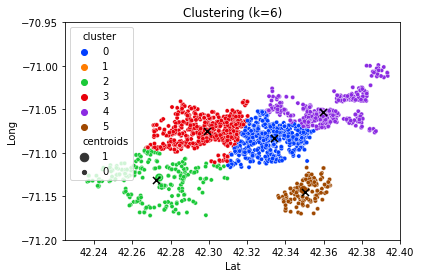

In [32]:
# Plot
fig, ax = plt.subplots()
sns.scatterplot(x="Lat", y="Long", data=dtf, palette=sns.color_palette("bright",k),hue='cluster', size="centroids", size_order=[1,0],legend="brief", ax=ax).set_title('Clustering (k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', marker="x")

plt.xlim(42.225, 42.4)
plt.ylim(-71.2, -70.95)